In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import pandas as pd
import torch, IPython, itertools, string
import random, time, warnings
import matplotlib.pyplot as plt
from matplotlib import animation
from munch import Munch

In [3]:
warnings.simplefilter('ignore')

In [4]:
class Point(torch.nn.Module):
    def __init__(self, linkage, name):
        super(Point, self).__init__()
        self.linkage = linkage
        self.name = name
        self.parent = None
        self._r = None
        
    def __repr__(self):
        raise Exception('Override this method.')
    
    @property
    def r(self):
        raise Exception('Override this property.')

    def root(self):
        raise Exception('Override this method.')
    
    def E(self):
        raise Exception('Override this method.')

In [5]:
class AtPoint(Point):
    def __init__(self, linkage, name, at):
        super(AtPoint, self).__init__(linkage, name)
        self._r = torch.nn.Parameter(torch.tensor(at).to(torch.float))
    
    def __repr__(self):
        label = self.__class__.__name__[:-5]
        return('[{}]Point_{}(at={})'.format(label, self.name, str(self.r.tolist())))
    
    @property
    def r(self):
        return(self._r)

    def root(self):
        return(self)
    
    def E(self):
        return(0)

In [6]:
class AnchorPoint(Point):
    def __init__(self, linkage, name, at):
        super(AnchorPoint, self).__init__(linkage, name)
        self._r = torch.tensor(at, requires_grad=False)
        
    def __repr__(self):
        label = self.__class__.__name__[:-5]
        return('[{}]Point_{}(at={})'.format(label, self.name, str(self.r.tolist())))
        
    @property
    def r(self):
        return(self._r)
        
    def root(self):
        return(self)
    
    def E(self):
        return(0)

In [7]:
class OnPointPoint(Point):
    def __init__(self, linkage, name, parent):
        super(OnPointPoint, self).__init__(linkage, name)
        self.parent = parent
        
    def __repr__(self):
        label = self.__class__.__name__[:-5]
        return('[{}]Point_{}(on={})'.format(label, self.name, str(self.parent)))
        
    @property
    def r(self):
        return(self.parent.r)
    
    def root(self):
        return(self.parent.root())
    
    def E(self):
        return(0)

In [8]:
class ToPointPoint(Point):
    def __init__(self, linkage, name, at, parent):
        super(ToPointPoint, self).__init__(linkage, name)
        self._r = torch.nn.Parameter(torch.tensor(at).to(torch.float))
        self.parent = parent
        
    def __repr__(self):
        label = self.__class__.__name__[:-5]
        return('[{}]Point_{}(to={})'.format(label, self.name, str(self.parent)))
        
    @property
    def r(self):
        return(self._r)
    
    def root(self):
        return(self)
    
    def E(self):
        return((self.r-self.parent.r).pow(2).sum())

In [9]:
class CalculatedPoint(Point):
    def __init__(self, linkage, name, parent):
        super(CalculatedPoint, self).__init__(linkage, name)
        self.parent = parent
        
    def __repr__(self):
        label = self.__class__.__name__[:-5]
        return('[{}]Point_{}(from={})'.format(label, self.name, str(self.parent.p1)))
        
    @property
    def r(self):
        if self.parent.ux is None:
            ax = torch.tensor([1,0,0], requires_grad=False).to(torch.float)
        elif type(self.parent.ux) is list:
            ax = torch.tensor(ux, requires_grad=False).to(torch.float)
        elif type(self.parent.ux).__bases__[0].__name__ is 'Line':
            ax = self.parent.ux.u
        else:
            raise Exception('ux must be None, a list, or a Line.')
        if self.parent.uz is None:
            az = torch.tensor([0,0,1], requires_grad=False).to(torch.float)
        elif type(self.parent.uz) is list:
            az = torch.tensor(uz, requires_grad=False).to(torch.float)
        elif type(self.parent.uz).__bases__[0].__name__ is 'Line':
            az = self.parent.uz.u
        else:
            raise Exception('uz must be None, a list, or a Line.')
        ay = torch.cross(az, ax)
        theta = self.parent.theta * np.pi/180
        phi = self.parent.phi * np.pi/180
        ux = torch.sin(phi)*torch.cos(theta)
        uy = torch.sin(phi)*torch.sin(theta)
        uz = torch.cos(phi)
        dr = self.parent.L * torch.cat([ux, uy, uz])
        R = torch.stack([ax, ay, az], dim=1)
        r = self.parent.p1.r + torch.matmul(R,dr)
        return(r)

    def root(self):
        return(self)
    
    def E(self):
        return(0)

In [10]:
class Line(torch.nn.Module):
    def __init__(self, linkage, name):
        super(Line, self).__init__()
        self.linkage = linkage
        self.name = name
        self.parent = None
        self.p1 = None
        self.p2 = None
        
    def __repr__(self):
        raise Exception('Override this method.')
        
    @property
    def r(self):
        return(self.p2.r-self.p1.r)

In [11]:
class FromPointLine(Line):
    def __init__(self, linkage, name, p, L, theta, phi=None, ux=None, uz=None):
        super(FromPointLine, self).__init__(linkage, name)
        self.L = L
        self.theta = torch.nn.Parameter(torch.tensor([theta]).to(torch.float))
        phi = 90 if phi is None else phi
        self.phi = torch.nn.Parameter(torch.tensor([phi]).to(torch.float))
        self.ux = ux
        self.uz = uz
        self.p1 = OnPointPoint(self.linkage, '{}.{}'.format(self.name, '1'), parent=p)
        self.p2 = CalculatedPoint(self.linkage, '{}.{}'.format(self.name, '2'), parent=self)
        
    def __repr__(self):
        label = self.__class__.__name__[:-4]
        return('[{}]Line_{}(p1={}, p2={})'.format(label, self.name, self.p1.name, self.p2.name))
    
    @property
    def u(self):
        return(self.r/self.L)

    def root(self):
        return(self)
    
    def E(self):
        return(0)

In [12]:
class OnLinePoint(Point):
    pass

In [13]:
class OnPointLine(Line):
    pass

In [14]:
class Linkage():
    def __init__(self):       
        self.points = Munch(torch.nn.ModuleDict({}))
        #self.anchors = torch.nn.ModuleDict({})
        self.lines = Munch(torch.nn.ModuleDict({}))
        #self.angles = torch.nn.ModuleDict({})
        self.names = {}
        for _type in ['point', 'line']:
            self.names[_type] = []
            letters = string.ascii_letters[-26:]
            if _type is 'line':
                letters = letters.lower()
            for n in range(3):
                for t in itertools.product(letters, repeat=n):
                    self.names[_type].append(''.join(t))
            self.names[_type] = iter(self.names[_type][1:])
        #self.names['anchor'] = self.names['point']
        self.plot = LinkagePlot(self)
        self.tolerance = 0.00001
    
    # Points
    
    def add_atpoint(self, at):
        name = next(self.names['point'])
        self.points[name] = AtPoint(self, name, at)
        self.plot.update()
        return(self.points[name])
    
    def add_anchorpoint(self, at):
        name = next(self.names['point'])
        self.points[name] = AnchorPoint(self, name, at)
        self.plot.update()
        return(self.points[name])
    
    def add_onpointpoint(self, parent):
        name = next(self.names['point'])
        self.points[name] = OnPointPoint(self, name, parent)
        self.plot.update()
        return(self.points[name])
    
    def add_topointpoint(self, at, parent):
        name = next(self.names['point'])
        self.points[name] = ToPointPoint(self, name, at, parent)
        self.plot.update()
        return(self.points[name])
    
    def add_onlinepoint(self):
        pass
    
    # Lines
    
    def add_frompointline(self, p, L, theta, phi=None, ux=None, uz=None):
        name = next(self.names['line'])
        self.lines[name] = FromPointLine(self, name, p, L, theta, phi, ux, uz)
        self.plot.update()
        return(self.lines[name])
    
    def add_onpointline(self):
        pass
        
    @property
    def N(self):
        N = 0
        N += len(self.points)
        #N += len(self.anchors)
        N += 2*len(self.lines)
        return(N)
    
    @property
    def M(self):
        return(len(self.lines))
     
    def parameters(self):
        parameters = []
        for point in self.points.values():
            for param in point.parameters():
                parameters.append(param)
        #for anchor in self.anchors.values():
        #    for param in anchor.parameters():
        #        parameters.append(param)
        for line in self.lines.values():
            for param in line.parameters():
                parameters.append(param)
        return(parameters)
        
    '''
    def xyz(self):
        xyz = torch.zeros((self.N, 3))
        n = 0
        for point in self.points.values():
            xyz[n] += point.r
            n += 1
        for anchor in self.anchors.values():
            xyz[n] += anchor.r
            n += 1
        for line in self.lines.values():
            xyz[n] += line.p1.r
            xyz[n+1] += line.p2.r
            n += 2
        return(xyz)
    '''
       
    def energy(self):
        E = 0.0
        for point in self.points.values():
            E += line.energy()
        for line in self.lines.values():
            E += line.energy()
        #for angle in self.angles.values():
        #    E += angle.energy()
        return(E)
            
    def update(self, max_num_epochs=10000):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001) #SGD
        for epoch in range(max_num_epochs):
            optimizer.zero_grad()
            E = self.energy()
            E.backward()
            optimizer.step()
            self.plot.E_list.append(E.item())
            if E <= self.tolerance:
                break
        if (E > self.tolerance or E.isnan()):
            raise Exception('Could not solve all constraints.')
        self.plot.update()
        time.sleep(0.01)

In [15]:
class LinkagePlot():
    def __init__(self, linkage):
        self.linkage = linkage
        self.origin = torch.tensor([0,0,0])
        self.E_list = [1.0]
        
        # Set up figure and axis
        self.size = 5
        self.lim = 5
        self.fig = plt.figure(figsize=(2*self.size,self.size))
        self.ax1 = self.fig.add_subplot(121, autoscale_on=False,
            xlim=(-self.lim,self.lim),
            ylim=(-self.lim,self.lim))
        self.ax2 = self.fig.add_subplot(122, autoscale_on=False,
            xlim=(0,1),
            ylim=(0,1))
        self.ax1.set_title('Configuration')
        self.ax2.set_title('log10(E)')
        
        self.ax1.scatter(
            [self.origin[0]], [self.origin[1]],
            marker='o', s=20, c='red', alpha=1, label='origin')
        
        self.points, self.anchors, self.lines = {}, {}, {}
            
        self.lnE_line, = self.ax2.plot([], [], 'b-', markersize=3, lw=0.5, label='log10(E)')
        time_template = ' t={:.0f}\n E={:.2f}\n T={:.5f}\n theta={:.0f}\n'
        self.time_text = self.ax1.text(0.05, 0.7, '', transform=self.ax1.transAxes)
        
    def update(self):
        
        for point_name in self.linkage.points.keys():
            print('point', point_name)
            if self.linkage.points[point_name].__class__.__name__ is 'AnchorPoint':
                color = 'orange'
            else:
                color = 'limegreen'
            if point_name not in self.points.keys():
                point = self.ax1.scatter([], [], s=20, c=color,
                    zorder=2, label=point_name)
                self.points[point_name] = point
            point = self.linkage.points[point_name]
            self.points[point_name].set_offsets(
                [[point.r[0],point.r[1]]])
                
        for line_name in self.linkage.lines.keys():
            print('line', line_name)
            ls, lw = ':', 1
            #if self.linkage.lines[line_name].is_constrained():
            #    ls, lw = '-', 1
            if line_name not in self.lines.keys():
                line, = self.ax1.plot([], [], linestyle=ls, markersize=3, lw=lw, c='black',
                    zorder=0, label=line_name)
                self.lines[line_name] = line
            line = self.linkage.lines[line_name]
            self.lines[line_name].set_data(
                [line.p1.r[0],line.p2.r[0]],
                [line.p1.r[1],line.p2.r[1]])
            self.lines[line_name].set_linestyle(ls)
            self.lines[line_name].set_linewidth(lw)
            
        self.lnE_line.set_xdata(torch.arange(0,len(self.E_list)))
        self.lnE_line.set_ydata(torch.log10(torch.tensor(self.E_list)))
        self.ax2.set_xlabel('Epoch')
        self.ax2.set_xlim(0,len(self.E_list))
        self.ax2.set_ylim(-10,10)
        self.time_text.set_text('')
        self.fig.canvas.draw()

<IPython.core.display.Javascript object>


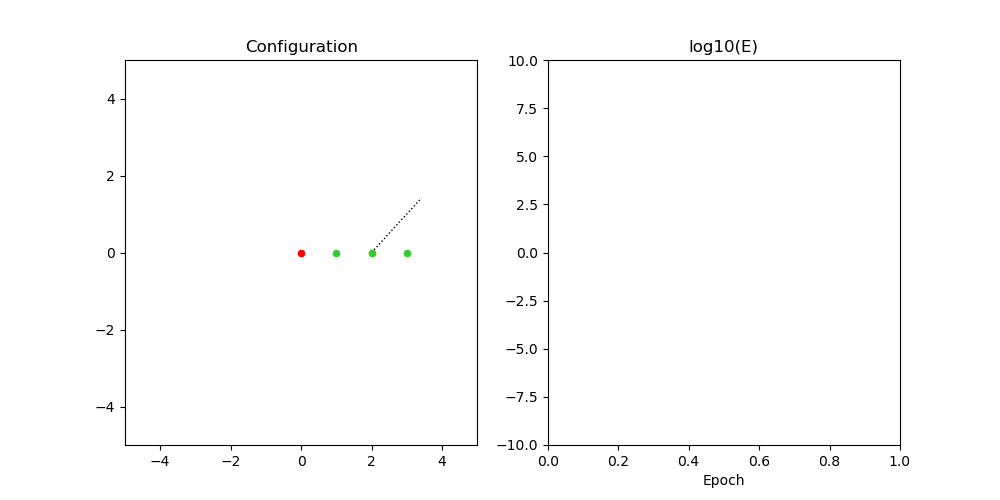

In [16]:
linkage = Linkage()

In [17]:
A = linkage.add_atpoint(at=[1,0,0])

point A


In [18]:
B = linkage.add_anchorpoint(at=[2,0,0])

point A
point B


In [19]:
C = linkage.add_onpointpoint(parent=B)

point A
point B
point C


In [20]:
D = linkage.add_topointpoint(parent=C, at=[3,0,0])

point A
point B
point C
point D


In [21]:
cd = linkage.add_frompointline(p=C, L=2, theta=45, phi=None, ux=None, uz=None)

point A
point B
point C
point D
line a


In [22]:
zz

NameError: name 'zz' is not defined

In [ ]:
class Point(torch.nn.Module):
    def __init__(self, linkage, name, at=None, on=None, anchored_at=None):
        super(Point, self).__init__()
        self.linkage = linkage
        self.name = name
        if at is not None:
            self.mode = 'at'
            self.type = 'free_point'
            self.parent = None
            self._r = torch.nn.Parameter(torch.tensor(at).to(torch.float))
        elif on is not None:
            self.mode = 'on'
            self.type = 'co_point'
            self.parent = on
            if self.parent.__class__.__name__ is 'Point':
                self._r = self.parent.r
            elif self.parent.__class__.__name__ is 'Line':
                raise Exception()
        elif anchored_at is not None:
            self.mode = 'anchored_at'
            self.type = 'anchored_point'
            self.parent = None
            self._r = torch.tensor(anchored_at).to(torch.float)
        else:
            self.mode = None
            self.type = 'null_point'
            self.parent = None
            self._r = None
        self.alpha = torch.nn.Parameter(torch.tensor([0.5]).to(torch.float))
    
    def __repr__(self):
        if self.mode is 'at':
            return('Point_{}(at={})'.format(self.name, str(self.r.tolist())))
        elif self.mode is 'on':
            return('Point_{}(on={})'.format(self.name, str(self.parent)))
        elif self.mode is 'anchored_at':
            return('Point_{}(anchored_at={})'.format(self.name, str(self.r.tolist())))
        else:
            return('Point_{}(None)'.format(self.name))
        
    @property
    def r(self):
        if self.parent is None:
            return(self._r)
        elif self.parent.__class__.__name__ is 'Point':
            return(self.parent.r)
        elif self.parent.__class__.__name__ is 'Line':
            return(self.alpha*self.parent.p1.r + (1-self.alpha)*self.parent.p2.r)

    def root(self):
        if self.parent is None:
            return(self)
        elif self.parent.__class__.__name__ is not 'Point':
            return(self)
        return(self.parent.root())
    
    def constrain_on(self, parent):
        self.mode = 'on'
        self.type = 'co_point'
        self.parent = parent
        try:
            self.linkage.update()
        except:
            pass

In [ ]:
class Line(torch.nn.Module):
    def __init__(self, linkage, name, r1, r2):
        super(Line, self).__init__()
        self.linkage = linkage
        self.name = name
        self.target_length = None
        if r1.__class__.__name__ is 'Point':
            self.p1 = Point(self.linkage, '{}{}'.format(self.name, '1'), on=r1)
        else:
            self.p1 = Point(self.linkage, '{}{}'.format(self.name, '1'), at=r1)
        if r2.__class__.__name__ is 'Point':
            self.p2 = Point(self.linkage, '{}{}'.format(self.name, '2'), on=r2)
        else:
            self.p2 = Point(self.linkage, '{}{}'.format(self.name, '2'), at=r2)
        self.mode = None
        self.parent = None
        
    def __repr__(self):
        return('Line_{}(p1={}, p2={})'.format(self.name, str(self.p1), str(self.p2)))
    
    @property
    def r(self):
        r = self.p2.r - self.p1.r
        return(r)
    
    def length(self):
        L = (self.p2.r-self.p1.r).pow(2).sum().pow(0.5)
        return(L)
    
    def constrain_length(self, L=None):
        if L is None:
            self.target_length = self.length().item()
        else:
            self.target_length = L
        self.linkage.update()
        
    def is_constrained(self):
        return(self.target_length is not None)
        
    def soft_abs(self, x):
        a = 10.0
        y = a*(x.abs()).pow(3)
        y /= (1.0+a*x.pow(2))
        return(y)
        
    def energy(self):
        E = 0.0
        if self.target_length is not None:
            d = self.length() - self.target_length
            E += d.pow(2) + 0.0*torch.abs(d)
        return(E)
    
    def constrain_on(self, parent):
        self.parent = parent
        if self.parent.__class__.__name__ is 'Point':
            self.mode = 'on_point'
        elif self.parent.__class__.__name__ is 'Line':
            self.mode = 'on_line'
        self.linkage.update()

In [ ]:
'''
class Angle(torch.nn.Module):
    def __init__(self, linkage, line1, line2):
        super(Angle, self).__init__()
        self.linkage = linkage
        self.line1 = line1
        self.line2 = line2
        self.target_theta = None
        self.axis = None
        self.ccw = False
        
    def __repr__(self):
        return('Angle({},{})'.format(self.line1.name, self.line2.name))
    
    def theta(self, ccw=False):
        r1 = self.line1.r
        r2 = self.line2.r
        if self.line1.p1.root() is not self.line2.p1.root():
            r2 = -r2
        u1 = r1/(r1.pow(2).sum().pow(0.5))
        u2 = r2/(r2.pow(2).sum().pow(0.5))
        cos_theta = (u1*u2).sum()
        theta = torch.arccos(cos_theta)
        if ccw is True:
            s = torch.sign(torch.cross(u1, u2)[2])
            theta = np.pi*(1-s)+s*theta
        theta *= 180/np.pi
        return(theta)
    
    def constrain_angle(self, theta=None, axis=None, ccw=False):
        self.ccw = ccw
        if axis is None:
            self.axis = torch.tensor([0,0,1]).to(torch.float)
        else:
            self.axis = axis/(axis.pow(2).sum().pow(0.5))
        if theta is None:
            self.target_theta = self.theta()
        else:
            theta %= 360
            self.target_theta = torch.tensor(theta).to(torch.float)
        self.linkage.update()
        
    def is_constrained(self):
        return(self.target_theta is not None)
        
    def soft_abs(self, x):
        a = 10.0
        y = a*(x.abs()).pow(3)
        y /= (1.0+a*x.pow(2))
        return(y)
        
    def energy(self):
        E = 0.0
        if self.target_theta is not None:
            rx = self.line1.r
            ux = rx/(rx.pow(2).sum().pow(0.5))
            if self.line1.p1.root() is not self.line2.p1.root():
                ux = -ux
                origin = torch.tensor(self.line1.p2.r.tolist()).to(torch.float)
            else:
                origin = torch.tensor(self.line1.p1.r.tolist()).to(torch.float)
            free_point = self.line2.p2
            uz = self.axis
            uy = torch.cross(uz, ux)
            target_point = 0.0
            target_point += origin
            target_point += torch.cos(self.target_theta*np.pi/180)*ux
            target_point += torch.sin(self.target_theta*np.pi/180)*uy
            target_point = torch.tensor(target_point.tolist()).to(torch.float)
            E += (target_point-free_point.r).pow(2).sum()
            #E += self.soft_abs((self.theta(self.ccw)*np.pi/180-self.target_theta)*np.pi/180)
            #E += torch.abs(torch.cos(self.theta(self.ccw)*np.pi/180)-torch.cos(self.target_theta*np.pi/180))
            #E += torch.abs(torch.sin(self.theta(self.ccw)*np.pi/180)-torch.sin(self.target_theta*np.pi/180))
        return(E)
''';

In [ ]:
class Linkage():
    def __init__(self):       
        self.points = torch.nn.ModuleDict({})
        self.anchors = torch.nn.ModuleDict({})
        self.lines = torch.nn.ModuleDict({})
        self.angles = torch.nn.ModuleDict({})
        self.names = {}
        for _type in ['point', 'line']:
            self.names[_type] = []
            letters = string.ascii_letters[-26:]
            if _type is 'line':
                letters = letters.lower()
            for n in range(3):
                for t in itertools.product(letters, repeat=n):
                    self.names[_type].append(''.join(t))
            self.names[_type] = iter(self.names[_type][1:])
        self.names['anchor'] = self.names['point']
        self.plot = LinkagePlot(self)
        self.tolerance = 0.00001
    
    def add_point_at(self, r):
        name = next(self.names['point'])
        self.points[name] = Point(self, name, at=r)
        self.plot.update()
        return(self.points[name])
        
    def add_point_on(self, p):
        name = next(self.names['point'])
        self.points[name] = Point(self, name, on=p)
        self.plot.update()
        return(self.points[name])
    
    def add_anchor_at(self, r):
        name = next(self.names['anchor'])
        self.anchors[name] = Point(self, name, anchored_at=r)
        self.plot.update()
        return(self.anchors[name])
    
    def add_line(self, r1, r2):
        name = next(self.names['line'])
        self.lines[name] = Line(self, name, r1, r2)
        self.plot.update()
        return(self.lines[name])
        
    def add_angle(self, line1, line2):
        name = '{}_{}'.format(line1.name, line2.name)
        self.angles[name] = Angle(self, line1, line2)
        self.plot.update()
        return(self.angles[name])
        
    @property
    def N(self):
        N = 0
        N += len(self.points)
        N += len(self.anchors)
        N += 2*len(self.lines)
        return(N)
    
    @property
    def M(self):
        return(len(self.lines))
     
    def parameters(self):
        parameters = []
        for point in self.points.values():
            for param in point.parameters():
                parameters.append(param)
        for anchor in self.anchors.values():
            for param in anchor.parameters():
                parameters.append(param)
        for line in self.lines.values():
            for param in line.parameters():
                parameters.append(param)
        return(parameters)
        
    def xyz(self):
        xyz = torch.zeros((self.N, 3))
        n = 0
        for point in self.points.values():
            xyz[n] += point.r
            n += 1
        for anchor in self.anchors.values():
            xyz[n] += anchor.r
            n += 1
        for line in self.lines.values():
            xyz[n] += line.p1.r
            xyz[n+1] += line.p2.r
            n += 2
        return(xyz)
        
    def energy(self):
        E = 0.0
        for line in self.lines.values():
            E += line.energy()
        for angle in self.angles.values():
            E += angle.energy()
        return(E)
            
    def update(self, max_num_epochs=10000):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001) #SGD
        for epoch in range(max_num_epochs):
            optimizer.zero_grad()
            E = self.energy()
            E.backward()
            optimizer.step()
            self.plot.E_list.append(E.item())
            if E <= self.tolerance:
                break
        if (E > self.tolerance or E.isnan()):
            raise Exception('Could not solve all constraints.')
        self.plot.update()
        time.sleep(0.01)

In [ ]:
class LinkagePlot():
    def __init__(self, linkage):
        self.linkage = linkage
        self.origin = torch.tensor([0,0,0])
        self.E_list = [10000.0]
        
        # Set up figure and axis
        self.size = 5
        self.lim = 5
        self.fig = plt.figure(figsize=(2*self.size,self.size))
        self.ax1 = self.fig.add_subplot(121, autoscale_on=False,
            xlim=(-self.lim,self.lim),
            ylim=(-self.lim,self.lim))
        self.ax2 = self.fig.add_subplot(122, autoscale_on=False,
            xlim=(0,1),
            ylim=(0,1))
        self.ax1.set_title('Configuration')
        self.ax2.set_title('log10(E)')
        
        self.ax1.scatter(
            [self.origin[0]], [self.origin[1]],
            marker='o', s=20, c='red', alpha=1, label='origin')
        
        self.points, self.anchors, self.lines = {}, {}, {}
            
        self.lnE_line, = self.ax2.plot([], [], 'b-', markersize=3, lw=0.5, label='log10(E)')
        time_template = ' t={:.0f}\n E={:.2f}\n T={:.5f}\n theta={:.0f}\n'
        self.time_text = self.ax1.text(0.05, 0.7, '', transform=self.ax1.transAxes)
        
    def update(self):
        
        for point_name in self.linkage.points.keys():
            if point_name not in self.points.keys():
                point = self.ax1.scatter([], [], s=20, c='limegreen',
                    zorder=2, label=point_name)
                self.points[point_name] = point
            point = self.linkage.points[point_name]
            self.points[point_name].set_offsets(
                [[point.r[0],point.r[1]]])
                
        for anchor_name in self.linkage.anchors.keys():
            if anchor_name not in self.anchors.keys():
                anchor = self.ax1.scatter([], [], s=20, c='orange',
                    zorder=1, label=anchor_name)
                self.anchors[anchor_name] = anchor
            anchor = self.linkage.anchors[anchor_name]
            self.anchors[anchor_name].set_offsets(
                [[anchor.r[0],anchor.r[1]]])
                
        for line_name in self.linkage.lines.keys():
            ls, lw = ':', 1
            if self.linkage.lines[line_name].is_constrained():
                ls, lw = '-', 1
            if line_name not in self.lines.keys():
                line, = self.ax1.plot([], [], linestyle=ls, markersize=3, lw=lw, c='black',
                    zorder=0, label=line_name)
                self.lines[line_name] = line
            line = self.linkage.lines[line_name]
            self.lines[line_name].set_data(
                [line.p1.r[0],line.p2.r[0]],
                [line.p1.r[1],line.p2.r[1]])
            self.lines[line_name].set_linestyle(ls)
            self.lines[line_name].set_linewidth(lw)
            
        self.lnE_line.set_xdata(torch.arange(0,len(self.E_list)))
        self.lnE_line.set_ydata(torch.log10(torch.tensor(self.E_list)))
        self.ax2.set_xlabel('Epoch')
        self.ax2.set_xlim(0,len(self.E_list))
        self.ax2.set_ylim(-10,10)
        self.time_text.set_text('')
        self.fig.canvas.draw()

In [ ]:
# Turn crank while simultaneously increasing crank length
# Implement Newton solver?

In [ ]:
linkage = Linkage()

In [ ]:
A = linkage.add_point_at([0,2,0])

In [ ]:
B = linkage.add_point_at([-2,1,0])

In [ ]:
C = linkage.add_point_at([2,1,0])

In [ ]:
Z = linkage.add_anchor_at([0,-1,0])

In [ ]:
bc = linkage.add_line(B,C)

In [ ]:
az = linkage.add_line(A,Z)

In [ ]:
A.constrain_on(bc) ######### fix update()

In [ ]:
az.constrain_length()

In [ ]:
az.constrain_length(0)

In [ ]:
ab = linkage.add_line(A,B)

In [ ]:
ab.constrain_length(2)

In [ ]:
bc = linkage.add_line(B,C)

In [ ]:
bc.constrain_length(4)

In [ ]:
ab.constrain_length(0.5)

In [ ]:
linkage = Linkage()

In [ ]:
A = linkage.add_point_at([0,0,0])

In [ ]:
B = linkage.add_anchor_at([-2,0,0])

In [ ]:
C = linkage.add_anchor_at([2,0,0])

In [ ]:
D = linkage.add_point_at([0,1,0])

In [ ]:
E = linkage.add_point_at([-0.25,0,0])

In [ ]:
bc = linkage.add_line(B,C) #bc.constrain_length(4)

In [ ]:
ba = linkage.add_line(B,A)

In [ ]:
ba.constrain_length(2)

In [ ]:
A.constrain_on(bc)

In [ ]:
CC = linkage.add_point_at([0,2,0])

In [ ]:
acc = linkage.add_line(A,CC)

In [ ]:
acc.constrain_length(2)

In [ ]:
D.constrain_on(acc)

In [ ]:
ad = linkage.add_line(A,D)

In [ ]:
ad.constrain_length(1)

In [ ]:
ed = linkage.add_line(E,D)

In [ ]:
ed.constrain_length(1)

In [ ]:
E.constrain_on(bc)

In [ ]:
be = linkage.add_line(B,E)

In [ ]:
be.constrain_length(3.999)

In [ ]:
BB = linkage.add_point_at([-2,-1,0])

In [ ]:
DD = linkage.add_point_at([0,1,0])

In [ ]:
EE = linkage.add_point_at([-1,-0.5,0])

In [ ]:
add = linkage.add_line(A,DD)

In [ ]:
add.constrain_length(1)

In [ ]:
bbcc = linkage.add_line(BB,CC)

In [ ]:
EE.constrain_on(bbcc)

In [ ]:
bbee = linkage.add_line(BB,EE)

In [ ]:
bbee.constrain_length(1.25)

In [ ]:
eedd = linkage.add_line(EE,DD)

In [ ]:
eedd.constrain_length(1)

In [ ]:
bbcc.constrain_length(4)

In [ ]:
be.constrain_length(3.2)

In [ ]:
#A.constrain_on(bbcc)

In [ ]:
zz

In [ ]:
AA.constrain_on(acc)

In [ ]:
aadd = linkage.add_line(AA,DD)

In [ ]:
aadd.constrain_length(1)

In [ ]:
EE.constrain_on(acc)

In [ ]:
eedd = linkage.add_line(EE,DD)

In [ ]:
eedd.constrain_length(1)

In [ ]:
dee = linkage.add_line(D,EE)

In [ ]:
dee.constrain_length(0.5)

In [ ]:
be.constrain_length(1)

In [ ]:
be.constrain_length(3.99)

In [ ]:
dee.constrain_length(3.9)

In [ ]:
zz

In [ ]:
G = linkage.add_anchor_at([0,4,0])

In [ ]:
fg = linkage.add_line(F,G)

In [ ]:
fg.constrain_length(8)

In [ ]:
zz

In [ ]:
A.constrain_on(fg)

In [ ]:
ga = linkage.add_line(G,A)

In [ ]:
ga.constrain_length(4)

In [ ]:
H = linkage.add_point_at([-3,-1,0])

In [ ]:
ha = linkage.add_line(H,A)

In [ ]:
gh = linkage.add_line(G,H)

In [ ]:
gh.constrain_length(4.5)

In [ ]:
H.constrain_on(fg)

In [ ]:
zz

In [ ]:
ha.constrain_length(2) ##########

In [ ]:
gh.constrain_length(5.5)

In [ ]:
be.constrain_length(0.5)

In [ ]:
gh.constrain_length(7)

In [ ]:
be.constrain_length(3)

In [ ]:
gh.constrain_length(3)

In [ ]:
zz

In [ ]:
Z = linkage.add_anchor_at([0,0,0])

In [ ]:
az = linkage.add_line(A,Z)

In [ ]:
az.constrain_length(0)

In [ ]:
az.constrain_length(0)

In [ ]:
#

In [ ]:
zz

In [ ]:
H = linkage.add_point_at([2,-0.5,0])

In [ ]:
ch = linkage.add_line(C,H)

In [ ]:
H.constrain_on(gf)

In [ ]:
gf.constrain_length()

In [ ]:
#ch.constrain_length(2)

In [ ]:
zz

In [ ]:
linkage = Linkage()

In [ ]:
A = linkage.add_anchor_at([0,0,0])

In [ ]:
B = linkage.add_anchor_at([0,1,0])

In [ ]:
ux = linkage.add_line(linkage.anchors['A'],linkage.anchors['B']).r

In [ ]:
uz = torch.tensor([0,0,1]).to(torch.float)

In [ ]:
theta = 135

In [ ]:
uy = torch.cross(uz, ux)

In [ ]:
r = np.cos(theta*np.pi/180)*ux + np.sin(theta*np.pi/180)*uy

In [ ]:
C = linkage.add_point_at(r.tolist())

In [ ]:
linkage.add_line(linkage.anchors['A'],C)

In [ ]:
zz

In [ ]:
linkage = Linkage()

In [ ]:
A = linkage.add_anchor_at([0,0,0])

In [ ]:
B = linkage.add_anchor_at([1,0,0])

In [ ]:
a = linkage.add_line(linkage.anchors['A'],linkage.anchors['B'])

In [ ]:
num_segments = 5

In [ ]:
arc_points = []
arc_points.append(B)

In [ ]:
for i in range(num_segments):
    #r = arc_points[-1].r + torch.tensor([-0.2,0.2,0.0])
    C = linkage.add_point_at([0,1,0]) #r.tolist())
    arc_points.append(C)
    b = linkage.add_line(A,C)
    b.constrain_length(1)
    c = linkage.add_line(C,arc_points[-2])
    L = 2*np.sin(0.5*(np.pi/2)/num_segments)
    c.constrain_length(L)

In [ ]:
c.constrain_length(1)

In [ ]:
zz

In [ ]:
linkage = Linkage()

In [ ]:
linkage.add_anchor_at([-1,1,0])

In [ ]:
linkage.add_point_at([0,1.25,0])

In [ ]:
linkage.add_anchor_at([3,1,0])

In [ ]:
linkage.add_line(linkage.anchors['A'],linkage.points['B'])

In [ ]:
linkage.add_line(linkage.anchors['C'],linkage.anchors['A']) ############

In [ ]:
linkage.lines['a'].constrain_length(1)

In [ ]:
linkage.add_angle(linkage.lines['b'], linkage.lines['a'])

In [ ]:
linkage.angles['b_a'].constrain_angle(45, ccw=True)

In [ ]:
linkage.add_point_at([3,4,0])

In [ ]:
linkage.add_line(linkage.points['B'],linkage.points['D'])

In [ ]:
linkage.add_line(linkage.points['D'],linkage.anchors['C'])

In [ ]:
linkage.lines['c'].constrain_length(5)

In [ ]:
linkage.lines['d'].constrain_length(4)

In [ ]:
for theta in np.linspace(0,720,50):
    linkage.angles['b_a'].constrain_angle(theta, ccw=True) # 'd_a'